## 19. TensorFlow卷積神經網路CNN辨識手寫數字

In [13]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()  # 關閉 TF2 行為，回到 TF1 模式
import numpy as np
from time import time

# 載入 MNIST 資料集
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# 正規化數據 (0~255 -> 0~1)
x_train = x_train / 255.0
x_test = x_test / 255.0

# 展平（Flatten） 28x28 -> 784
# 為了與 TensorFlow 1.x 的占位符（placeholder）輸入格式匹配
x_train = x_train.reshape(-1, 784)
x_test = x_test.reshape(-1, 784)

# one-hot 編碼
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

# 拆分訓練資料與驗證資料（80% 訓練、20% 驗證）
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(
    x_train, y_train, test_size=0.2, random_state=42)

print("訓練資料形狀：", x_train.shape, y_train.shape)
print("驗證資料形狀：", x_val.shape, y_val.shape)
print("測試資料形狀：", x_test.shape, y_test.shape)

訓練資料形狀： (48000, 784) (48000, 10)
驗證資料形狀： (12000, 784) (12000, 10)
測試資料形狀： (10000, 784) (10000, 10)


### 建立共用函數

In [26]:
# 定義 weight 函數,用於建立權重 (weight) 張量
def weight(shape):
  return tf.Variable(tf.truncated_normal(shape, stddev=0.1), name='W')

# 定義 bias 函數,用於建立偏差 (bias) 張量
def bias(shape):
  return tf.Variable(tf.constant(0.1, shape=shape), name='b')

# 定義 conv2d 函數,用於進行卷積運算
def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1,1,1,1], padding='SAME')

# 建立 max_pool_2x2 函數,用於建立池化層
def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1,2,2,1], strides=[1,2,2,1], padding='SAME')

### 建立模型

In [15]:
# 輸入層(Input Layer)
with tf.name_scope('Input_Layer'):
  x = tf.placeholder("float", shape=[None, 784], name="x")
  x_image = tf.reshape(x, [-1, 28, 28, 1])

# 建立卷積層1
with tf.name_scope('C1_Conv'):
  W1 = weight([5, 5, 1, 16])
  b1 = bias([16])
  Conv1 = conv2d(x_image, W1) + b1
  C1_Conv = tf.nn.relu(Conv1)

# 建立池化層1
with tf.name_scope('C1_Pool'):
  C1_Pool = max_pool_2x2(C1_Conv)

# 卷積層2
with tf.name_scope('C2_Conv'):
  W2 = weight([5, 5, 16, 36])
  b2 = bias([36])
  Conv2 = conv2d(C1_Pool, W2) + b2
  C2_Conv = tf.nn.relu(Conv2)

# 建立池化層2
with tf.name_scope('C2_Pool'):
  C2_Pool = max_pool_2x2(C2_Conv)

# 建立平坦層
with tf.name_scope('D_Flat'):
  D_Flat = tf.reshape(C2_Pool, [-1, 1764])

# 建立隱藏層
with tf.name_scope('D_Hidden_Layer'):
  W3 = weight([1764, 128])
  b3 = bias([128])
  D_Hidden = tf.nn.relu(tf.matmul(D_Flat, W3) + b3)
  keep_prob = tf.placeholder(tf.float32)
  D_Hidden_Dropout = tf.nn.dropout(D_Hidden, keep_prob)

# 建立輸出層(Output_Layer )
with tf.name_scope('Output_Layer'):
  W4 = weight([128, 10])
  b4 = bias([10])
  y_predict = tf.nn.softmax(tf.matmul(D_Hidden_Dropout, W4) + b4)

In [16]:
# 定義訓練方式
with tf.name_scope("optimizer"):
  y_label = tf.placeholder("float", shape=[None, 10], name="y_label")
  loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=y_predict, labels=y_label))
  optimizer = tf.train.AdamOptimizer(learning_rate=0.0001).minimize(loss_function)

with tf.name_scope("evaluate_model"):
  correct_prediction = tf.equal(tf.argmax(y_predict, 1), tf.argmax(y_label, 1))
  accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

### 進行訓練

In [17]:
trainEpochs = 10
batchSize = 100
totalBatchs = int(len(x_train) / batchSize)

epoch_list, accuracy_list, loss_list = [], [], []
val_loss_list, val_accuracy_list = [], []

sess = tf.Session()
sess.run(tf.global_variables_initializer())

startTime = time()
for epoch in range(trainEpochs):
  for i in range(totalBatchs):
    batch_x = x_train[i*batchSize:(i+1)*batchSize]
    batch_y = y_train[i*batchSize:(i+1)*batchSize]
    sess.run(optimizer, feed_dict={x: batch_x, y_label: batch_y, keep_prob: 0.8})

  # 訓練集表現（loss + acc）
  train_loss, train_acc = sess.run([loss_function, accuracy],
    feed_dict={x: x_train, y_label: y_train, keep_prob: 1.0})
  loss_list.append(train_loss)
  accuracy_list.append(train_acc)

  # 驗證集表現（val_loss + val_acc）
  val_loss, val_acc = sess.run([loss_function, accuracy],
    feed_dict={x: x_val, y_label: y_val, keep_prob: 1.0})
  val_loss_list.append(val_loss)
  val_accuracy_list.append(val_acc)

  epoch_list.append(epoch)

  print("Train Epoch:", '%02d' % (epoch+1),
        "Train Loss=", "{:.9f}".format(train_loss),
        "Train Accuracy=", train_acc,
        "Val Loss=", "{:.9f}".format(val_loss),
        "Val Accuracy=", val_acc)

  # Early stopping 檢查條件
  if epoch > 3 and val_loss > val_loss_list[-2]:
      print("Validation loss increasing, early stop!")
      break

duration = time() - startTime
print("Train Finished takes:", duration)

Train Epoch: 01 Train Loss= 1.584861636 Train Accuracy= 0.9026667 Val Loss= 1.583404303 Val Accuracy= 0.9063333
Train Epoch: 02 Train Loss= 1.538567662 Train Accuracy= 0.934125 Val Loss= 1.536933303 Val Accuracy= 0.9360833
Train Epoch: 03 Train Loss= 1.521555066 Train Accuracy= 0.94754165 Val Loss= 1.520385623 Val Accuracy= 0.9485833
Train Epoch: 04 Train Loss= 1.512827158 Train Accuracy= 0.9542083 Val Loss= 1.512180686 Val Accuracy= 0.9548333
Train Epoch: 05 Train Loss= 1.503373384 Train Accuracy= 0.9624583 Val Loss= 1.503710985 Val Accuracy= 0.96175
Train Epoch: 06 Train Loss= 1.498065472 Train Accuracy= 0.96695834 Val Loss= 1.498566389 Val Accuracy= 0.96816665
Train Epoch: 07 Train Loss= 1.494472623 Train Accuracy= 0.970375 Val Loss= 1.495206833 Val Accuracy= 0.9698333
Train Epoch: 08 Train Loss= 1.490511775 Train Accuracy= 0.9739375 Val Loss= 1.491822958 Val Accuracy= 0.97291666
Train Epoch: 09 Train Loss= 1.489602208 Train Accuracy= 0.9743958 Val Loss= 1.490485191 Val Accuracy= 0.

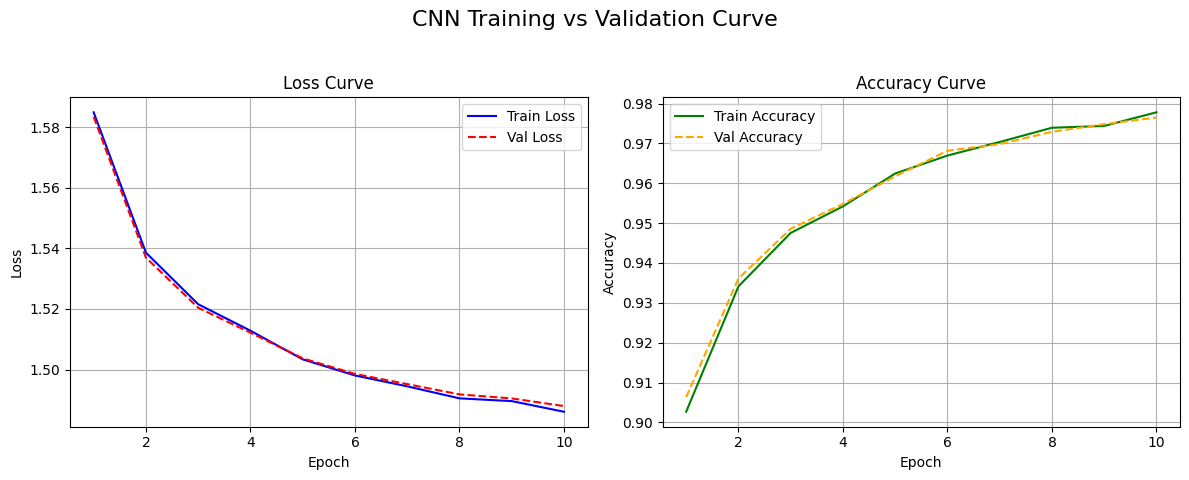

In [18]:
# 匯入套件
import matplotlib.pyplot as plt

# 自訂繪圖函數：顯示訓練過程中的 loss 與 accuracy 變化
def plot_training_history(
    loss_list, accuracy_list,
    val_loss_list, val_accuracy_list,
    title="Training vs Validation"
):
    epochs = range(1, len(loss_list) + 1)
    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss_list, 'b', label='Train Loss')
    plt.plot(epochs, val_loss_list, 'r--', label='Val Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy_list, 'g', label='Train Accuracy')
    plt.plot(epochs, val_accuracy_list, 'orange', linestyle='--', label='Val Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.grid(True)
    plt.legend()

    # 整體標題與排版
    plt.suptitle(title, fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# 使用此函數繪製訓練記錄（你之前紀錄的 loss_list 與 accuracy_list）
plot_training_history(
    loss_list, accuracy_list,
    val_loss_list, val_accuracy_list,
    title="CNN Training vs Validation Curve"
)

### 進行預測

In [19]:
#執行預測
prediction_result = sess.run(tf.argmax(y_predict, 1), feed_dict={x: x_test, keep_prob: 1.0})

In [20]:
import matplotlib.pyplot as plt

# 顯示圖片與預測結果的函數
def plot_images_labels_prediction(images, labels, prediction, start_id, num=10):
    plt.gcf().set_size_inches(12, 14)  # 設定整體大小
    if num > 25: num = 25  # 最多顯示 25 張圖
    for i in range(num):
        plt.subplot(5, 5, i+1)
        plt.imshow(images[start_id], cmap='binary')
        title = f"label={np.argmax(labels[start_id])}"
        if prediction is not None:
            title += f", pred={prediction[start_id]}"
        plt.title(title, fontsize=12)
        plt.xticks([]); plt.yticks([])
        start_id += 1
    plt.show()

### 查看預測結果

In [21]:
prediction_result[:10]

array([7, 2, 1, 0, 4, 1, 4, 9, 5, 9])

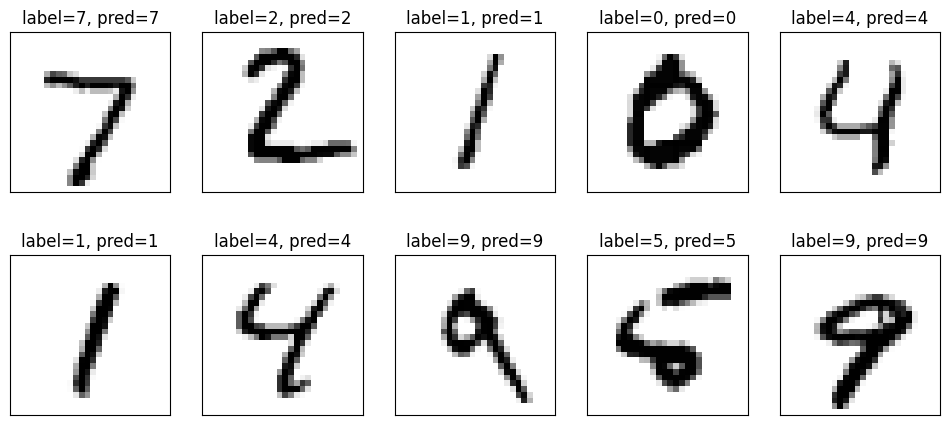

In [22]:
plot_images_labels_prediction(x_test.reshape(-1, 28, 28), y_test, prediction_result, start_id=0)

In [23]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

# 將 one-hot 的 y_test 轉為標籤值
y_true = np.argmax(y_test, axis=1)
y_pred = prediction_result

# 印出準確率、精確率、召回率、F1 分數
print("Accuracy Score:", accuracy_score(y_true, y_pred))
print("Precision Score (macro):", precision_score(y_true, y_pred, average='macro'))
print("Recall Score (macro):", recall_score(y_true, y_pred, average='macro'))
print("F1 Score (macro):", f1_score(y_true, y_pred, average='macro'))

# 如果想看每個類別的詳細報告（每個數字 0~9）
print("\nClassification Report:")
print(classification_report(y_true, y_pred))

Accuracy Score: 0.9777
Precision Score (macro): 0.9777563351691269
Recall Score (macro): 0.9776745117677663
F1 Score (macro): 0.9776558297727641

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       980
           1       0.99      0.99      0.99      1135
           2       0.96      0.98      0.97      1032
           3       0.99      0.97      0.98      1010
           4       0.98      0.98      0.98       982
           5       0.99      0.98      0.98       892
           6       0.98      0.99      0.98       958
           7       0.97      0.97      0.97      1028
           8       0.96      0.97      0.97       974
           9       0.98      0.95      0.97      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000



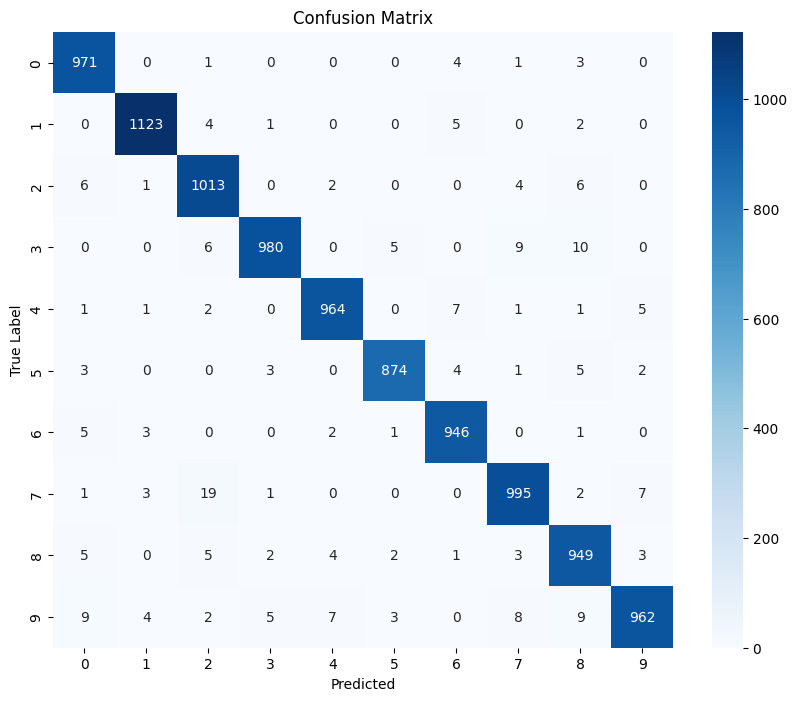

In [24]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()